# Importa as libraries

In [44]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt


In [58]:
df_train = pd.read_csv(r'data\flight_delays_train.csv')

In [59]:
df_test = pd.read_csv(r'data\flight_delays_test.csv')

In [ ]:
df_test.head()

# EDA

In [ ]:
# Identificar nulos
df_train.isnull().sum()

In [ ]:
# Identificar duplicar
df_train.shape == df_train.drop_duplicates().shape

In [ ]:
df_train.head()

# Colocando target 0 e 1

In [60]:
df_train['target'] = df_train['dep_delayed_15min'].map({'Y': 1, 'N': 0})

# Feature Engineering

In [ ]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

def get_part_of_day(dep_time):
    hour = dep_time // 100  # Pegamos apenas a hora (ex: 1422 → 14)
    if 0 <= hour < 6:
        return 'Madrugada'
    elif 6 <= hour < 12:
        return 'Manha'
    elif 12 <= hour < 18:
        return 'Tarde'
    else:
        return 'Noite'
    
tamanho_aeroporto = {
    ('ATL', 'LAX', 'DFW', 'DEN', 'ORD', 'JFK', 'MCO', 'LAS', 'CLT', 'MIA', 'SEA', 'EWR', 'SFO', 'PHX', 'IAH', 'BOS', 'FLL', 'MSP', 'LGA', 'DTW', 'EHL', 'SLC', 'BWI', 'BCA', 'SAN', 'IAD', 'EPA', 'BNA', 'AUS', 'MDW', 'HNL'): 2,
    ('DAL', 'PDX', 'STL', 'RDU', 'HOU', 'SMF', 'MSY', 'SJU', 'SJC', 'SNA', 'MCI', 'OAK', 'SAT', 'RSW', 'CLE', 'IND', 'PIT', 'CVG', 'CMH', 'PBI', 'OGG', 'JAX', 'ONT', 'BUR', 'BDL', 'CHS', 'MKE', 'ANC', 'ABQ', 'OMA', 'MEM', 'RIC', 'BOI'): 1
}


# Função para verificar se uma data é um feriado fixo
def is_holiday(row):
    # Feriados fixos (sem considerar o ano)
    fixed_holidays = {
        '01-01': 'New Year\'s Day',   # New Year's Day
        '07-04': 'Independence Day',  # Independence Day
        '12-25': 'Christmas Day',     # Christmas Day
        '11-11': 'Veterans Day',      # Veterans Day
    }
    
    # Criar a chave de feriado para comparar
    holiday_key = f'{str(row["Month"]).zfill(2)}-{str(row["DayofMonth"]).zfill(2)}'
    
    # Verificar se a data é um feriado fixo
    if holiday_key in fixed_holidays:
        return 1  # É um feriado fixo
    
    return 0 # Não é feriado

In [ ]:
df_train['Month'] = df_train['Month'].apply(lambda x: x[2:]).astype(int)
df_train['DayofMonth'] = df_train['DayofMonth'].apply(lambda x: x[2:]).astype(int)
df_train['DayOfWeek'] = df_train['DayOfWeek'].apply(lambda x: x[2:]).astype(int)

df_train['IsWeekend'] = df_train['DayOfWeek'].apply(lambda x: 1 if x in [6, 7] else 0)

df_train['Season'] = df_train['Month'].apply(get_season)
df_train = pd.get_dummies(df_train, columns=['Season'], dtype=int, drop_first=True)

df_train['PartOfDay'] = df_train['DepTime'].apply(get_part_of_day)
df_train = pd.get_dummies(df_train, columns=['PartOfDay'], dtype=int, drop_first=True)

df_train['Dest_size'] = df_train['Dest'].map(lambda x: next((size for airports, size in tamanho_aeroporto.items() if x in airports), 0))
df_train['Origin_size'] = df_train['Origin'].map(lambda x: next((size for airports, size in tamanho_aeroporto.items() if x in airports), 0))

# Enconder companhia
encoder_carrier = LabelEncoder()
df_train['UniqueCarrier_encoded'] = encoder_carrier.fit_transform(df_train['UniqueCarrier'])


# Encoder origem destino
encoder_origin_dest = LabelEncoder()
df_airport = pd.concat([df_train['Origin'], df_train['Dest']], axis=0).reset_index(drop=True)
encoder_origin_dest.fit_transform(df_airport)
df_train['Origin_encode'] = encoder_origin_dest.transform(df_train['Origin'])
df_train['Dest_encode'] = encoder_origin_dest.transform(df_train['Dest'])


df_train['Distance_by_Carrier'] = df_train['Distance'] * df_train['UniqueCarrier_encoded']
df_train['SizeDiff'] = df_train['Origin_size'] - df_train['Dest_size']
df_train['DepHour'] = df_train['DepTime'] // 100 
df_train['Dist_Hour'] = df_train['Distance'] * df_train['DepHour']

# Calcular a média do 'DepDelay' com base em 'UniqueCarrier_encoded' e 'target'
df_train['Carrier_AvgDelay'] = df_train.groupby(['UniqueCarrier_encoded'])['target'].transform('mean')

df_train['DayOfWeek_sin'] = np.sin(2 * np.pi * df_train['DayOfWeek'] / 7)
df_train['DayOfWeek_cos'] = np.cos(2 * np.pi * df_train['DayOfWeek'] / 7)

# Aplicando a função para marcar feriados
df_train['IsHoliday'] = df_train.apply(is_holiday, axis=1)


# Bins para distancia
df_train['Dist_bin'] = 0
# Apply the binning based on the 'Distance' column
df_train.loc[df_train.Distance <= 500, 'Dist_bin'] = 0
df_train.loc[(df_train.Distance > 500) & (df_train.Distance <= 1000), 'Dist_bin'] = 1
df_train.loc[(df_train.Distance > 1000) & (df_train.Distance <= 1500), 'Dist_bin'] = 2
df_train.loc[(df_train.Distance > 1500) & (df_train.Distance <= 2000), 'Dist_bin'] = 3
df_train.loc[(df_train.Distance > 2000) & (df_train.Distance <= 2500), 'Dist_bin'] = 4
df_train.loc[df_train.Distance > 2500, 'Dist_bin'] = 5


## Feature Engineering para as variáveis de teste

In [ ]:
df_test['Month'] = df_test['Month'].apply(lambda x: x[2:]).astype(int)
df_test['DayofMonth'] = df_test['DayofMonth'].apply(lambda x: x[2:]).astype(int)
df_test['DayOfWeek'] = df_test['DayOfWeek'].apply(lambda x: x[2:]).astype(int)

df_test['IsWeekend'] = df_test['DayOfWeek'].apply(lambda x: 1 if x in [6, 7] else 0)

df_test['Season'] = df_test['Month'].apply(get_season)
df_test = pd.get_dummies(df_test, columns=['Season'], dtype=int, drop_first=True)

df_test['PartOfDay'] = df_test['DepTime'].apply(get_part_of_day)
df_test = pd.get_dummies(df_test, columns=['PartOfDay'], dtype=int, drop_first=True)

df_test['Dest_size'] = df_test['Dest'].map(lambda x: next((size for airports, size in tamanho_aeroporto.items() if x in airports), 0))
df_test['Origin_size'] = df_test['Origin'].map(lambda x: next((size for airports, size in tamanho_aeroporto.items() if x in airports), 0))

# Substituir valores desconhecidos por 0 no teste
df_test['UniqueCarrier_encoded'] = df_test['UniqueCarrier'].apply(
    lambda x: encoder_carrier.transform([x])[0] if x in encoder_carrier.classes_ else 0
)

# Transformar no conjunto de teste, substituindo novos valores por 0
df_test['Origin_encode'] = df_test['Origin'].apply(
    lambda x: encoder_origin_dest.transform([x])[0] if x in encoder_origin_dest.classes_ else 0
)
df_test['Dest_encode'] = df_test['Dest'].apply(
    lambda x: encoder_origin_dest.transform([x])[0] if x in encoder_origin_dest.classes_ else 0
)

df_test['Distance_by_Carrier'] = df_test['Distance'] * df_test['UniqueCarrier_encoded']
df_test['SizeDiff'] = df_test['Origin_size'] - df_test['Dest_size']
df_test['DepHour'] = df_test['DepTime'] // 100 
df_test['Dist_Hour'] = df_test['Distance'] * df_test['DepHour']

# Calcular a média do 'target' no conjunto de teste com base no 'UniqueCarrier_encoded'
df_test['Carrier_AvgDelay'] = df_test['UniqueCarrier_encoded'].map(df_train.groupby('UniqueCarrier_encoded')['target'].mean())

df_test['DayOfWeek_sin'] = np.sin(2 * np.pi * df_test['DayOfWeek'] / 7)
df_test['DayOfWeek_cos'] = np.cos(2 * np.pi * df_test['DayOfWeek'] / 7)

# Bins para distancia
df_test.loc[df_test.Distance <= 500, 'Dist_bin'] = 0
df_test.loc[(df_test.Distance > 500) & (df_test.Distance <= 1000), 'Dist_bin'] = 1
df_test.loc[(df_test.Distance > 1000) & (df_test.Distance <= 1500), 'Dist_bin'] = 2
df_test.loc[(df_test.Distance > 1500) & (df_test.Distance <= 2000), 'Dist_bin'] = 3
df_test.loc[(df_test.Distance > 2000) & (df_test.Distance <= 2500), 'Dist_bin'] = 4
df_test.loc[df_test.Distance > 2500, 'Dist_bin'] = 5


In [102]:
x_col = [
    'Month',
    'DayofMonth',
    'DayOfWeek',
    'IsWeekend',
    'DepTime',
    'Distance',
    'UniqueCarrier_encoded',
    'Origin_encode',
    'Dest_encode',
    'Season_Spring',
    'Season_Summer',
    'Season_Winter',
    'PartOfDay_Manha',
    'PartOfDay_Noite',
    'PartOfDay_Tarde',
    'Dest_size',
    'Origin_size',
    'Distance_by_Carrier', 'SizeDiff',
       'DepHour', 'Dist_Hour', 'Carrier_AvgDelay', 'DayOfWeek_sin',
       'DayOfWeek_cos', 'IsHoliday', 'Dist_bin'
]

y_col = ['target']

In [103]:
x = df_train[x_col]
y = df_train[y_col]

# Treina modelo

In [104]:
from sklearn.model_selection import train_test_split

# Dividindo os dados em treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [105]:
models = {
    'RandomForest': RandomForestClassifier(n_estimators=500, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=10000, random_state=42),
    'NaiveBayes': GaussianNB(),
    'Bagging': BaggingClassifier(n_estimators=50, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(learning_rate=0.1, iterations=1000, depth=6, random_state=42, verbose=0),
    'RedeNeural': MLPClassifier(hidden_layer_sizes=(128, 64, 32), activation='relu', solver='adam', max_iter=500, random_state=42)
}
results = []

for name, model in models.items():
    # Treinamento do modelo
    model.fit(x_train, y_train.values.ravel())
    
    # Fazer previsões para o conjunto de treino e teste
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)
    
    # Calcular as métricas de avaliação para o treino
    accuracy_train = accuracy_score(y_train.values.ravel(), y_pred_train)
    precision_train = precision_score(y_train.values.ravel(), y_pred_train)
    recall_train = recall_score(y_train.values.ravel(), y_pred_train)
    f1_train = f1_score(y_train.values.ravel(), y_pred_train)
    
    # Calcular AUC-ROC para o treino - Nota: AUC-ROC requer probabilidades (não rótulos de classe)
    y_pred_train_prob = model.predict_proba(x_train)[:, 1]  # Probabilidades da classe positiva
    auc_roc_train = roc_auc_score(y_train.values.ravel(), y_pred_train_prob)
    
    # Calcular as métricas de avaliação para o teste
    accuracy_test = accuracy_score(y_test.values.ravel(), y_pred_test)
    precision_test = precision_score(y_test.values.ravel(), y_pred_test)
    recall_test = recall_score(y_test.values.ravel(), y_pred_test)
    f1_test = f1_score(y_test.values.ravel(), y_pred_test)
    
    # Calcular AUC-ROC para o teste
    y_pred_test_prob = model.predict_proba(x_test)[:, 1]
    auc_roc_test = roc_auc_score(y_test.values.ravel(), y_pred_test_prob)
    
    # Salvar modelo treinado
    joblib.dump(model, f'modelo_{name}.pkl')

    # Armazenar os resultados para o treino e o teste
    results.append((
        name, 
        accuracy_train, precision_train, recall_train, f1_train, auc_roc_train, 
        accuracy_test, precision_test, recall_test, f1_test, auc_roc_test
    ))
    
    # Exibir as métricas de treinamento
    print(f"\nModelo: {name}")
    print("Métricas de Treinamento:")
    print(f"Acurácia: {accuracy_train:.4f}")
    print(f"Precisão: {precision_train:.4f}")
    print(f"Recall: {recall_train:.4f}")
    print(f"F1-Score: {f1_train:.4f}")
    print(f"AUC-ROC: {auc_roc_train:.4f}")
    
    # Exibir as métricas de teste
    print("\nMétricas de Teste:")
    print(f"Acurácia: {accuracy_test:.4f}")
    print(f"Precisão: {precision_test:.4f}")
    print(f"Recall: {recall_test:.4f}")
    print(f"F1-Score: {f1_test:.4f}")
    print(f"AUC-ROC: {auc_roc_test:.4f}")
    

# Comparar os resultados
results_df = pd.DataFrame(results, columns=[
    'Modelo', 
    'Acurácia Treinamento', 'Precisão Treinamento', 'Recall Treinamento', 'F1-Score Treinamento', 'AUC-ROC Treinamento',
    'Acurácia Teste', 'Precisão Teste', 'Recall Teste', 'F1-Score Teste', 'AUC-ROC Teste'
])


print(results_df)



Modelo: RandomForest
Métricas de Treinamento:
Acurácia: 1.0000
Precisão: 1.0000
Recall: 1.0000
F1-Score: 1.0000
AUC-ROC: 1.0000

Métricas de Teste:
Acurácia: 0.8236
Precisão: 0.6667
Recall: 0.1323
F1-Score: 0.2208
AUC-ROC: 0.7445

Modelo: GradientBoosting
Métricas de Treinamento:
Acurácia: 0.8177
Precisão: 0.7163
Recall: 0.0744
F1-Score: 0.1348
AUC-ROC: 0.7310

Métricas de Teste:
Acurácia: 0.8188
Precisão: 0.7070
Recall: 0.0696
F1-Score: 0.1267
AUC-ROC: 0.7271


c:\Users\r_san\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Modelo: LogisticRegression
Métricas de Treinamento:
Acurácia: 0.8093
Precisão: 0.5429
Recall: 0.0037
F1-Score: 0.0074
AUC-ROC: 0.6738

Métricas de Teste:
Acurácia: 0.8108
Precisão: 0.3750
Recall: 0.0024
F1-Score: 0.0047
AUC-ROC: 0.6800

Modelo: NaiveBayes
Métricas de Treinamento:
Acurácia: 0.7312
Precisão: 0.3314
Recall: 0.4016
F1-Score: 0.3632
AUC-ROC: 0.6827

Métricas de Teste:
Acurácia: 0.7379
Precisão: 0.3405
Recall: 0.4140
F1-Score: 0.3737
AUC-ROC: 0.6891

Modelo: Bagging
Métricas de Treinamento:
Acurácia: 0.9996
Precisão: 0.9999
Recall: 0.9978
F1-Score: 0.9988
AUC-ROC: 1.0000

Métricas de Teste:
Acurácia: 0.8218
Precisão: 0.6108
Recall: 0.1562
F1-Score: 0.2487
AUC-ROC: 0.7381

Modelo: DecisionTree
Métricas de Treinamento:
Acurácia: 1.0000
Precisão: 1.0000
Recall: 1.0000
F1-Score: 1.0000
AUC-ROC: 1.0000

Métricas de Teste:
Acurácia: 0.7354
Precisão: 0.3159
Recall: 0.3438
F1-Score: 0.3293
AUC-ROC: 0.5852
[LightGBM] [Info] Number of positive: 15266, number of negative: 64734
[Light

In [ ]:
# 2. Criar Stacking Ensemble
base_models = [(name, model) for name, model in models.items()]
stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression(), passthrough=True)
stacking_model.fit(x_train, y_train.values.ravel())

# Salvar Stacking
joblib.dump(stacking_model, 'modelo_Stacking.pkl')

# Avaliar Stacking
y_pred_test_stack = stacking_model.predict(x_test)
accuracy_test_stack = accuracy_score(y_test.values.ravel(), y_pred_test_stack)
auc_roc_test_stack = roc_auc_score(y_test.values.ravel(), stacking_model.predict_proba(x_test)[:, 1])

print(f"\nStacking - Acurácia Teste: {accuracy_test_stack:.4f}, AUC-ROC Teste: {auc_roc_test_stack:.4f}")


# Treina Catboost

## Treino com gridsearch

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from time import time

# Definindo o modelo CatBoost
catboost_model = CatBoostClassifier(silent=True, class_weights=[1, 3])

# Definindo o espaço de hiperparâmetros para a busca
param_grid = {
    'iterations': [100, 200, 300, 1000, 2000, 3000],
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bylevel': [0.7, 0.8, 0.9],
}

start = time()

# Realizando a busca em grade
grid_search = RandomizedSearchCV(catboost_model, param_grid, cv=3, scoring='roc_auc', verbose=10, n_jobs=-1)
grid_search.fit(x_train, y_train)

elapsed = time() - start

print(elapsed)

# Exibindo os melhores parâmetros encontrados
print("Melhores parâmetros:", grid_search.best_params_)

# Usando o melhor modelo encontrado para realizar previsões
best_catboost_model = grid_search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
541.1024503707886
Melhores parâmetros: {'subsample': 0.9, 'learning_rate': 0.01, 'l2_leaf_reg': 5, 'iterations': 3000, 'depth': 8, 'colsample_bylevel': 0.7}


## Treino manual

In [112]:
best_catboost_model = CatBoostClassifier(
    iterations=1000,               # Número de iterações moderado
    learning_rate=0.05,            # Reduzir a taxa de aprendizado
    depth=8,                       # Reduzir a profundidade das árvores
    l2_leaf_reg=3,                 # Aumentar a regularização L2
    subsample=0.8,                 # Usar 80% das amostras para cada árvore
    class_weights=[1, 2],
    eval_metric='AUC',
    silent=True,                   # Não exibir informações de progresso
)

# Treinando o modelo
best_catboost_model.fit(x_train, y_train)

In [113]:
# Previsões para o conjunto de treino
y_pred_train = best_catboost_model.predict(x_train)

# Previsões probabilísticas para AUC-ROC
y_pred_train_prob = best_catboost_model.predict_proba(x_train)[:, 1]

# Métricas para o conjunto de treino
precision_train = precision_score(y_train.values.ravel(), y_pred_train)
recall_train = recall_score(y_train.values.ravel(), y_pred_train)
f1_train = f1_score(y_train.values.ravel(), y_pred_train)
auc_roc_train = roc_auc_score(y_train.values.ravel(), y_pred_train_prob)

# Exibir resultados
print("Métricas para o Treinamento:")
print(f"Precisão: {precision_train:.4f}")
print(f"Recall: {recall_train:.4f}")
print(f"F1-Score: {f1_train:.4f}")
print(f"AUC-ROC: {auc_roc_train:.4f}")

Métricas para o Treinamento:
Precisão: 0.7328
Recall: 0.5182
F1-Score: 0.6071
AUC-ROC: 0.8945


# Avalia no teste

In [114]:
# Previsões para o conjunto de  teste
y_pred_test = best_catboost_model.predict(x_test)

# Previsões probabilísticas para AUC-ROC
y_pred_test_prob = best_catboost_model.predict_proba(x_test)[:, 1]

# Métricas para o conjunto de teste
precision_test = precision_score(y_test.values.ravel(), y_pred_test)
recall_test = recall_score(y_test.values.ravel(), y_pred_test)
f1_test = f1_score(y_test.values.ravel(), y_pred_test)
auc_roc_test = roc_auc_score(y_test.values.ravel(), y_pred_test_prob)

print("\nMétricas para o Teste:")
print(f"Precisão: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1-Score: {f1_test:.4f}")
print(f"AUC-ROC: {auc_roc_test:.4f}")


Métricas para o Teste:
Precisão: 0.5004
Recall: 0.3227
F1-Score: 0.3923
AUC-ROC: 0.7501


In [115]:
best_params = grid_search.best_params_ 
best_params = best_catboost_model.get_all_params()

# Instanciar o modelo final com os melhores parâmetros
final_model = CatBoostClassifier(
    best_params['iterations'],               # Número de iterações moderado
    best_params['learning_rate'],            # Reduzir a taxa de aprendizado
    best_params['depth'],                       # Reduzir a profundidade das árvores
    best_params['l2_leaf_reg'],                 # Aumentar a regularização L2
    best_params['subsample'],                 # Usar 80% das amostras para cada árvore
    silent=True,  
)


# Retreinar no conjunto completo de dados
final_model.fit(x, y)  # X é o conjunto de dados completo, y são os rótulos

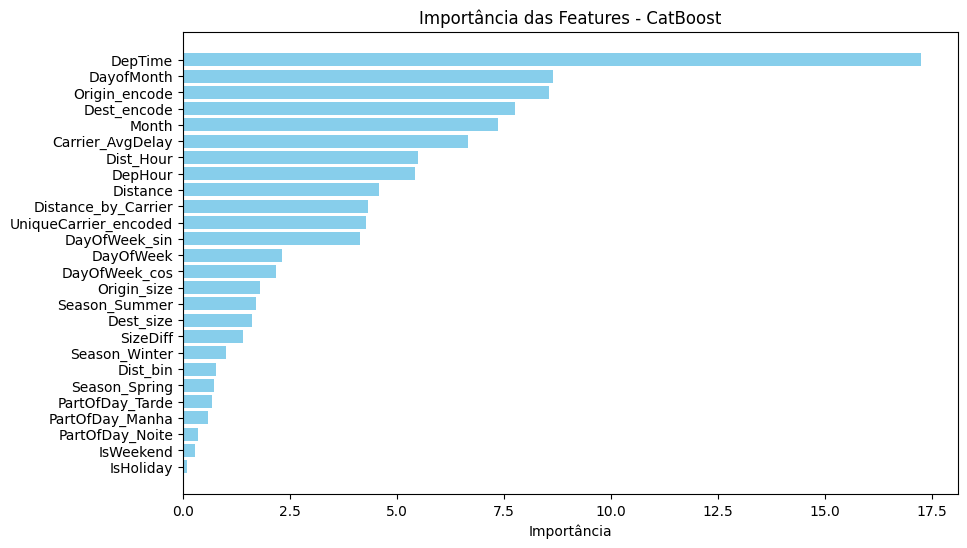

In [117]:
# Obter a importância das features
feature_importance = final_model.get_feature_importance()

# Criar um DataFrame com as importâncias das features
feature_names = x.columns  # Usando os nomes das colunas de X_train
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Ordenar as features pela importância
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualizar a importância das features
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importância')
plt.title('Importância das Features - CatBoost')
plt.gca().invert_yaxis()  # Inverter a ordem das barras para a mais importante no topo
plt.show()

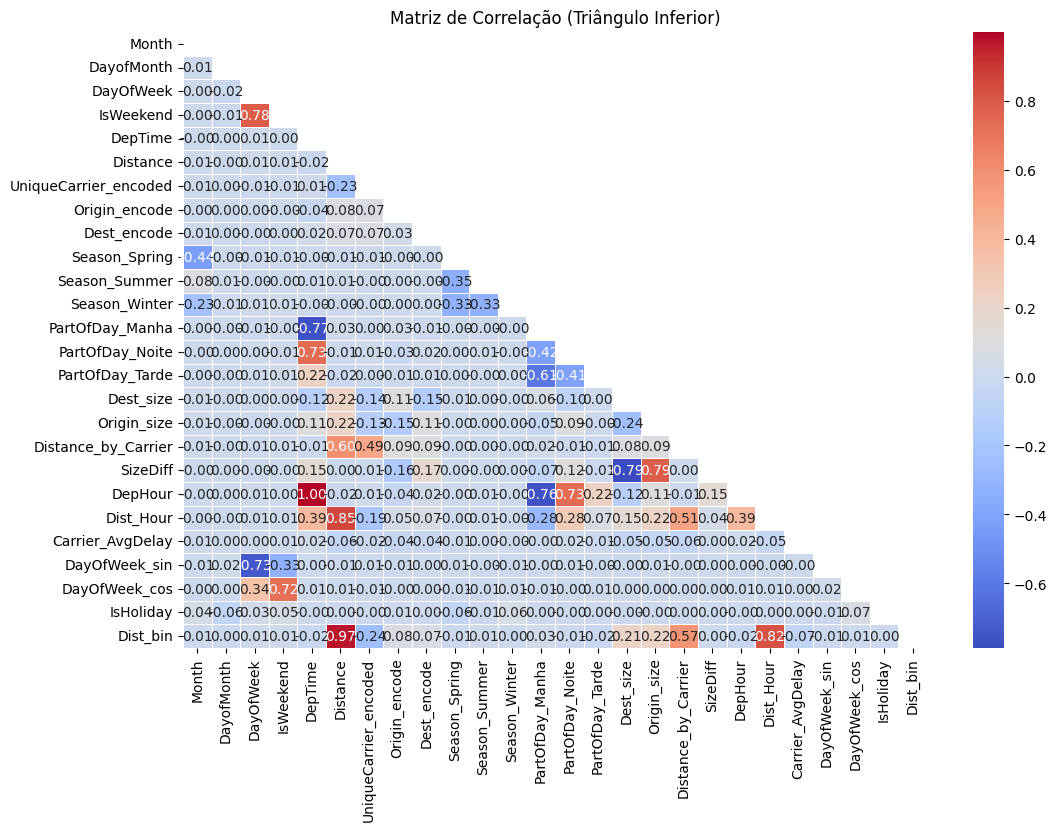

In [122]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Suponha que 'df_train' seja seu DataFrame de treino
# Calcular a correlação entre as features
correlation_matrix = x_train.corr()

# Máscara para o triângulo superior da matriz
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Visualizar a matriz de correlação (triângulo inferior) usando um heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, mask=mask)
plt.title('Matriz de Correlação (Triângulo Inferior)')
plt.show()

In [116]:
# Calcular as probabilidades para o conjunto de teste usando o modelo treinado
y_pred_final_prob = final_model.predict_proba(df_test[x_col])[:, 1]  # Probabilidade da classe 1 (target positivo)

# Criar um DataFrame com o 'id' e as probabilidades
df_final = pd.DataFrame({
    'id': df_test.index,  # Supondo que a coluna 'id' existe no seu conjunto de teste
    'dep_delayed_15min': y_pred_final_prob  # Probabilidades da classe positiva
})

# Salvar os dados finais em um arquivo CSV
df_final.to_csv('dados_finais.csv', index=False)

# Exibir as primeiras linhas do DataFrame para conferência
print(df_final.head())


   id  dep_delayed_15min
0   0           0.015064
1   1           0.046882
2   2           0.030371
3   3           0.226675
4   4           0.217584
